<a href="https://colab.research.google.com/github/puneethkumarvydya/Capstone-Project/blob/Moutusi's-Branch/Capstone_Project_AIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import tensorflow
tensorflow.__version__
import os
import pandas as pd
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/My Drive/CapstoneProject/') 
os.listdir()

['rsna-pneumonia-detection-challenge.zip',
 'GCP Credits Request Link - RSNA.txt',
 'stage_2_detailed_class_info.csv',
 'stage_2_sample_submission.csv',
 'stage_2_test_images',
 'stage_2_train_images',
 'stage_2_train_labels.csv']

In [4]:
from pathlib import Path
my_file = Path("GCP Credits Request Link - RSNA.txt")
if my_file.is_file():
    print("File isunzipped")
else:
  print("File is need to be zipped")


File isunzipped


In [7]:

from pathlib import Path
my_file = Path("GCP Credits Request Link - RSNA.txt")
if my_file.is_file():
    print("File isunzipped")
else:
  print("File is need to be zipped")
  from zipfile import ZipFile
  with ZipFile("rsna-pneumonia-detection-challenge.zip",'r') as z:
    z.extractall()
    os.listdir()  

File isunzipped


In [8]:
classinfo = pd.read_csv("stage_2_detailed_class_info.csv")

In [9]:
classinfo.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [10]:
classinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [11]:
classinfo.nunique()

patientId    26684
class            3
dtype: int64

In [12]:
classinfo.rename(columns = {'class':'Class'}, inplace = True)

In [13]:
classinfo.Class.value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: Class, dtype: int64

In [14]:
 submission= pd.read_csv("stage_2_sample_submission.csv")

In [15]:
submission.head()

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


In [16]:

train_label = pd.read_csv("stage_2_train_labels.csv")

In [17]:
train_label.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [39]:
train_label.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [18]:
train_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [19]:
!pip install -q pydicom

     |████████████████████████████████| 1.9MB 5.3MB/s 


In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom as dicom

In [21]:
DIR_test='./stage_2_test_images'
onlyfiles = next(os.walk(DIR_test))[2] #dir is your directory path as string
print ("Total test images:",len(onlyfiles))

Total test images: 3000


In [22]:
DIR_train='./stage_2_train_images'
onlyfiles = next(os.walk(DIR_train))[2] #dir is your directory path as string
print ("Total training images:",len(onlyfiles))

Total training images: 26684


In [24]:
#os.listdir(path=DIR_test)

In [29]:
ds=dicom.dcmread(DIR_test + '/'+'26e7295a-4039-463f-974f-e6402e5c9fa0.dcm')

In [35]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.1521.1517874291.365076
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1521.1517874291.365076
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

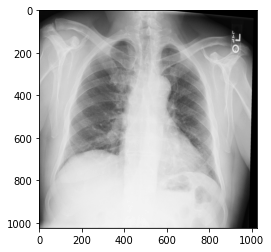

In [41]:
import cv2
#cv2.imshow(ds.pixel_array)
plt.imshow(ds.pixel_array,cmap='gray')

In [27]:
import os
import cv2
count = 0
d = "stage_2_train_images"
for path in os.listdir(d):
  img = cv2.imread(path, 1)
  if img is  None:
        count += 1
print("Total non readdable Training images:")
print(count)

 

Total non readdable Training images:
26684


In [31]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    print("total",total)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))
missing_data(train_label)

total height       20672
width        20672
y            20672
x            20672
Target           0
patientId        0
dtype: int64


,height,width,y,x,Target,patientId
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


In [40]:
missing_data(classinfo)

total Class        0
patientId    0
dtype: int64


,Class,patientId
Total,0.0,0.0
Percent,0.0,0.0


11821
9555
8851


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


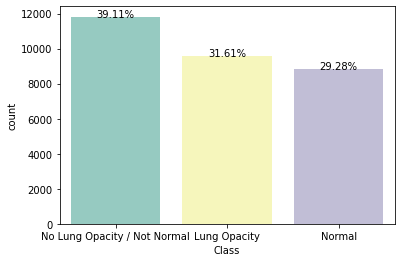

In [43]:
import seaborn as sns
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(classinfo))
sns.countplot(classinfo['Class'],order = classinfo['Class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    print(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [47]:
train_class_df = train_label.merge(classinfo, left_on='patientId', right_on='patientId', how='inner')
train_class_df.head()

,patientId,x,y,width,height,Target,Class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


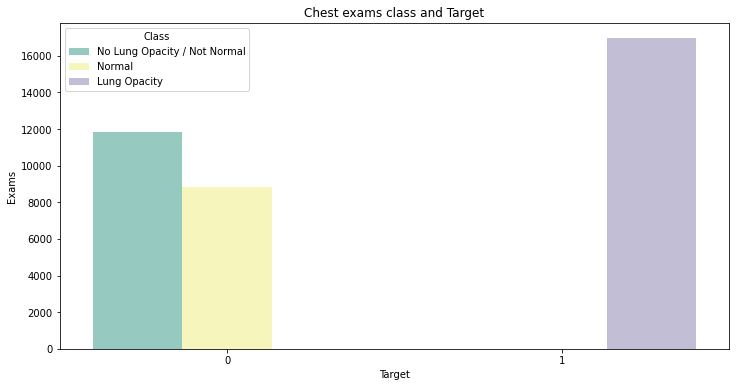

In [50]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['Class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='Class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

In [54]:
tmp.values

array([11821,  8851, 16957])

In [55]:
train_class_df.head()

,patientId,x,y,width,height,Target,Class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<Figure size 432x288 with 0 Axes>

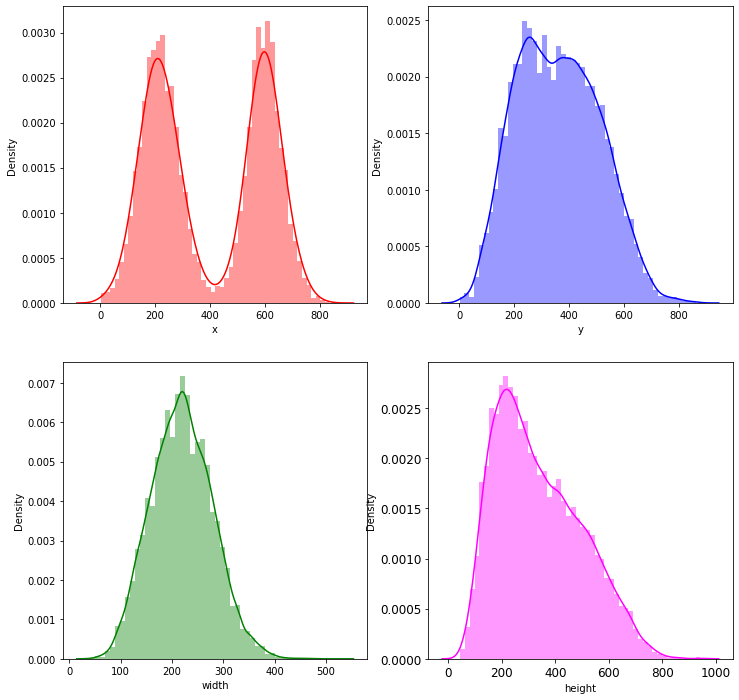

In [56]:
target1 = train_class_df[train_class_df['Target']==1]
#sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [57]:
#Check for duplicate
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique())  


Unique patientId in  train_class_df:  26684


Number of unique patinet ID is same as number of dicom image in the training set

In [59]:
tmp = train_class_df.groupby(['patientId','Target', 'Class'])['patientId'].count()
tmp

patientId                             Target  Class                       
0004cfab-14fd-4e49-80ba-63a80b6bddd6  0       No Lung Opacity / Not Normal    1
000924cf-0f8d-42bd-9158-1af53881a557  0       Normal                          1
000db696-cf54-4385-b10b-6b16fbb3f985  1       Lung Opacity                    4
000fe35a-2649-43d4-b027-e67796d412e0  1       Lung Opacity                    4
001031d9-f904-4a23-b3e5-2c088acd19c6  1       Lung Opacity                    4
                                                                             ..
fffb2395-8edd-4954-8a89-ffe2fd329be3  1       Lung Opacity                    4
fffba05a-1635-4545-9bbd-57ad4cfe8d27  0       Normal                          1
fffc95b5-605b-4226-80ab-62caec682b22  0       No Lung Opacity / Not Normal    1
fffcff11-d018-4414-971a-a7cefa327795  0       No Lung Opacity / Not Normal    1
fffec09e-8a4a-48b1-b33e-ab4890ccd136  0       No Lung Opacity / Not Normal    1
Name: patientId, Length: 26684, dtype: int64

In [60]:
tmp.values

array([1, 1, 4, ..., 1, 1, 1])

In [62]:
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
df.head()
tmp = df.groupby(['Exams','Target','Class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Exams', 'Target','Class', 'Entries']
df2

,Exams,Target,Class,Entries
0,1,0,No Lung Opacity / Not Normal,11821
1,1,0,Normal,8851
2,1,1,Lung Opacity,2614
3,4,1,Lung Opacity,3266
4,9,1,Lung Opacity,119
5,16,1,Lung Opacity,13


In [65]:
df2.Exams.value_counts()

1     3
4     1
9     1
16    1
Name: Exams, dtype: int64

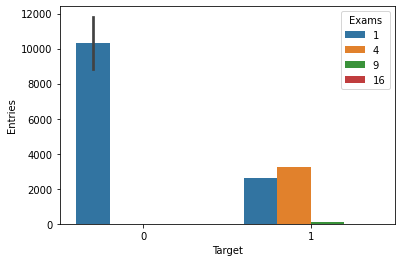

In [69]:
sns.barplot(x = 'Target', y='Entries', hue='Exams',data=df2)

In [83]:
os.listdir()

['rsna-pneumonia-detection-challenge.zip',
 'GCP Credits Request Link - RSNA.txt',
 'stage_2_detailed_class_info.csv',
 'stage_2_sample_submission.csv',
 'stage_2_test_images',
 'stage_2_train_images',
 'stage_2_train_labels.csv']

In [119]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join("./stage_2_train_images/",patientImage)
        print(imagePath)
        
        #data_row_img_data = dicom.read_file(imagePath)
        data_row_img_data = dicom.dcmread(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dicom.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['Class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

./stage_2_train_images/bd88f2af-7d9f-44a8-8004-ea76250dc9b2.dcm
./stage_2_train_images/3bc8260d-31f1-45a4-bad5-06d0936f9bed.dcm
./stage_2_train_images/ffd787b6-59ca-48cb-bd15-bcedd52cf37c.dcm
./stage_2_train_images/3c183f4c-967f-41e5-a87a-d8dd5aac0fde.dcm
./stage_2_train_images/401b69a0-3d07-47f8-bfea-4bc30aa51403.dcm
./stage_2_train_images/f8767c5d-9024-43d9-9044-843f2cec00c7.dcm
./stage_2_train_images/261341d3-1df2-4cf4-b9a8-b1e02a124900.dcm
./stage_2_train_images/8a504f1d-b42c-4328-8571-f4e0a8e0fb5a.dcm
./stage_2_train_images/d0370ad5-e503-4826-be45-b710ffc5066f.dcm


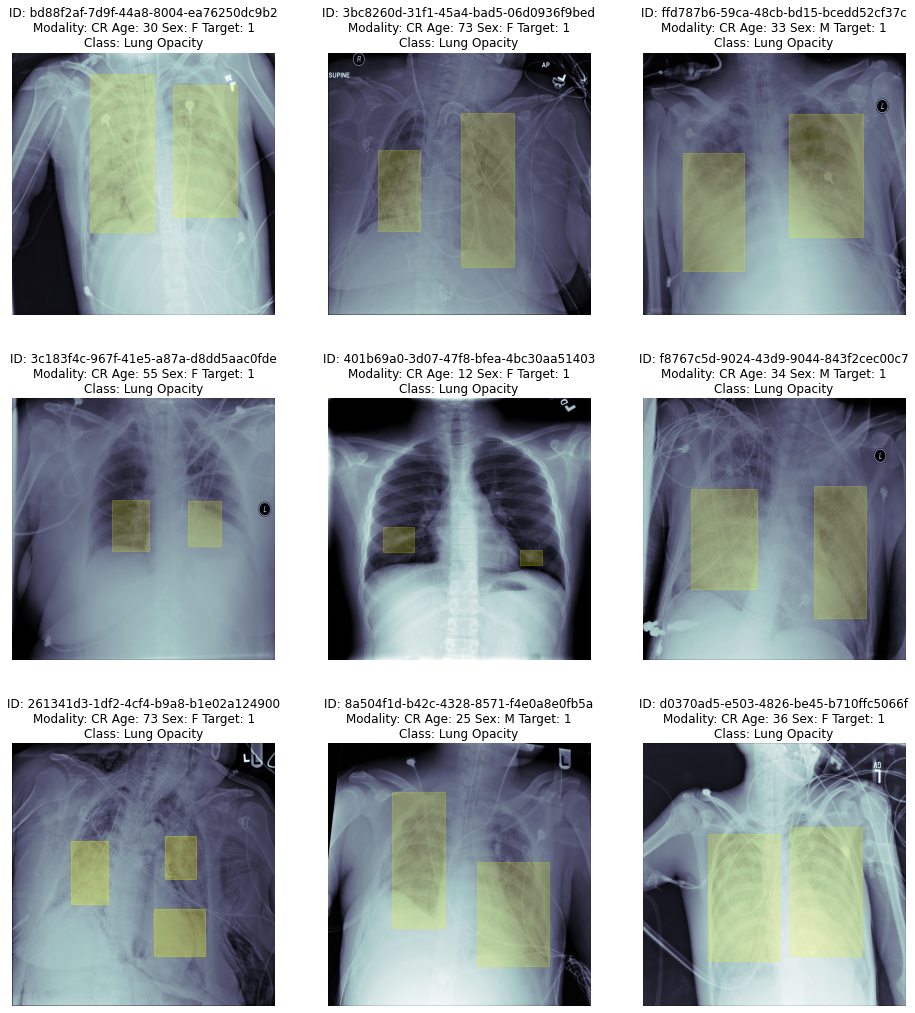

In [120]:
from matplotlib.patches import Rectangle
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))
#dicom_file_path = os.path.join("stage_2_train_images/",samplePatientID)
#print(dicom_file_path)

In [108]:
#data_row_img_data = dcm.read_file("/content/drive/My Drive/CapstoneProject/stage_2_train_images/33d21874-f7b1-413c-8013-0b4a98d12fb9.dcm")
img = dicom.dcmread("./stage_2_train_images/33d21874-f7b1-413c-8013-0b4a98d12fb9.dcm")
img.PatientSex

'F'

In [73]:
data=train_class_df[train_class_df['Target']==1].sample(9)

In [75]:
img_data = list(data.T.to_dict().values())
img_data

[{'Class': 'Lung Opacity',
  'Target': 1,
  'height': 149.0,
  'patientId': '7c086e53-4bad-4bc6-9ff6-292614b69e07',
  'width': 107.0,
  'x': 583.0,
  'y': 394.0},
 {'Class': 'Lung Opacity',
  'Target': 1,
  'height': 265.0,
  'patientId': 'd29caa55-2027-4078-8d93-c6aaa25f7044',
  'width': 193.0,
  'x': 238.0,
  'y': 231.0},
 {'Class': 'Lung Opacity',
  'Target': 1,
  'height': 331.0,
  'patientId': 'b915ae1a-346d-4e9f-b1fd-a72e0a78a864',
  'width': 253.0,
  'x': 683.0,
  'y': 316.0},
 {'Class': 'Lung Opacity',
  'Target': 1,
  'height': 475.0,
  'patientId': 'b171964f-e911-42a4-a1ec-e57128258011',
  'width': 219.0,
  'x': 507.0,
  'y': 476.0},
 {'Class': 'Lung Opacity',
  'Target': 1,
  'height': 140.0,
  'patientId': 'ac3f6948-11eb-430c-b7eb-3df21e68a3ae',
  'width': 242.0,
  'x': 91.0,
  'y': 428.0},
 {'Class': 'Lung Opacity',
  'Target': 1,
  'height': 346.0,
  'patientId': 'd5835755-52dd-4a9d-a70e-6a49fcbbe1c8',
  'width': 193.0,
  'x': 632.0,
  'y': 235.0},
 {'Class': 'Lung Opacit

In [126]:
def create_data_from_dicom_data(path):
  images = os.listdir(path)
  for img in images:
    print(img)
    ds = dicom.dcmread(img)
    
    break

In [127]:

create_data_from_dicom_data('./stage_2_train_images')

f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm


In [147]:
columns_name=['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']
dicom_df = pd.DataFrame(columns=columns_name)